## Experiment Overview
Reward given by reaching target location, with error margin of paddle_height / 2, with a velocity of 0
 - Architectures tried: 
 
    paddle: relative distance to goal (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    
    paddle: relative distance to goal, paddle: velocity (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    
    paddle: relative distance to goal, paddle: velocity, paddle: acceleration (5 runs with 10 hidden layers, 5 runs with 30 hidden layers, 5 runs with 100 hidden layers) 
    
    (run for 1000 episodes (~100-250k steps) each) (_Note_: Only 3 runs with 100 hidden neurons for acceleration)
    

 - Reward function specifics (at every time step): 
   - Reaching target location with error margin, with a velocity of 0: +2.5
     - Upon receiving reward, new target location is generated by `(int(np.random.random() * 100 + 20))`
   - Up or down action taken: -0.01
   - No-op:  -0.005

#### Note: There is a demo of the controller in action at the bottom of the notebook

## Notes on Results
 - _Main insight I got out of this_: Getting stuck at local minima is especially bad for RL agents, since that leads them to act in such a way that they generate uninteresting/useless training data for themselves. So not only is the state of their paramaters bad, but the quality of their training data is also bad.
 - Adding more hidden units seems to help, but the results aren't statistically significant, especially since more than half the runs got stuck at poor local minima.
 - If we build an accurate ball future location predictor, we should be able to send where the ball will cross the paddle x axis to the controller, and the agent should be unbeatable.

## Future experiments
 - It may be worth switching to PPO for later experiments. These networks are relatively small and stable, but making updates to larger networks will probably be less stable.
 - Might be worth exploring deeper architectures to see if this can be done better.  
 (I am currently training a two layer agent for 10,000 episodes. Two layers should be enough to ensure reliable performance on this task, but we'll see)
 - For dealing with initially bad local minima in training, should we reinitialize those with bad initial weights? (while tracking the number of re-initializations)
   - For example, measure the performance of 100 random initializations for some initialization method, set some cutoff based on a percentile, and when training new agents re-initialize the weights if they don’t meet that initial cutoff

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

In [49]:
DIR = './results/'
exp_filenames = sorted([f for f in os.listdir(DIR) if os.path.isfile(DIR+f)])

In [50]:
#exp_filenames

#### The experiment files are organized as follows:
 - The last line contains end - start time
 - The middles lines contain the episode number and the reward gained

In [51]:
## Gather experiment data into lists
exps = []
for filename in exp_filenames:
    with open(DIR+filename) as fp:
        exp = []
        exp.append(filename)
        for line in fp:
            exp.append(line)
        exps.append(exp)

In [52]:
## Organize experiment results into lists including filename, runtime of experiment, and array of results,
## with the first column representing the episode number, and the second column representing the reward received
exp_results = []
for exp in exps:
    results = []
    filename = exp[0]
    time_to_run = float(exp[-1].strip("\n"))
    for i in range(1,len(exp)-1):
        results.append(np.array(list(map(float, exp[i].strip("\n").rsplit(" ")))))
    results = np.array(results)
    exp_results.append([filename, time_to_run, results])

In [53]:
def get_exps_info(exps, num_experiments=5, avg_over=100):
    total_reward = 0
    running_reward = []
    running_means = []
    variances = []
    res_idx = 2
    rwd_idx = 1
    for i in range(num_experiments):
        running_mean = []
        for j in range(len(exps[i][res_idx])):
            total_reward += exps[i][res_idx][j][rwd_idx]
            running_reward.append(total_reward)
            if j >= avg_over and j % avg_over == 0:
                running_mean.append(np.mean(exps[i][res_idx][j-avg_over:j][:,rwd_idx]))
        variances.append(np.var(exps[i][res_idx][:,1]))
        running_means.append(running_mean)
    return running_reward, running_means, variances

In [54]:
def display_timing_info(exps, num_experiments=5):
    fname_idx=0; time_idx=1
    for i in range(num_experiments):
        print(exps[i][fname_idx] + " took an average of {0:.0f} seconds or {1:.1f} minutes to run".format(exps[i][time_idx], exps[i][time_idx]/60))

In [55]:
def plot5(running_reward, running_means, exps):
    plt.figure(figsize=(14,5))
    plt.subplot(121)
    plt.title("Total reward / time")
    plt.plot(range(len(running_reward)), running_reward)
    plt.subplot(122)
    plt.title("Running average reward of previous " + str(avg_over) + " mini-games")
    plt.plot(range(len(running_means[0])), running_means[0], label=exps[0][0])
    plt.plot(range(len(running_means[1])), running_means[1], label=exps[1][0])
    plt.plot(range(len(running_means[2])), running_means[2], label=exps[2][0])
    plt.plot(range(len(running_means[3])), running_means[3], label=exps[3][0])
    plt.plot(range(len(running_means[4])), running_means[4], label=exps[4][0])
    plt.legend()

# Results grouped by experiment type

In [56]:
pos = exp_results[13:28]
pos_vel = exp_results[28:43]
pos_vel_acc = exp_results[0:13]

## Relative positions of the paddle to target location
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [57]:
avg_over = 50
exps = pos[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

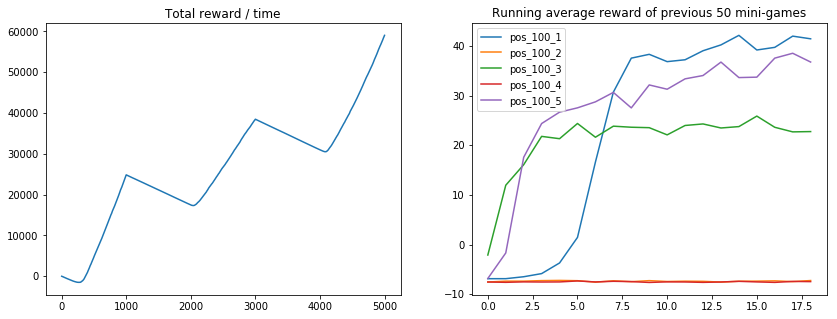

In [58]:
plot5(running_reward, running_means, exps)

In [59]:
display_timing_info(exps)

pos_100_1 took an average of 1372 seconds or 22.9 minutes to run
pos_100_2 took an average of 1338 seconds or 22.3 minutes to run
pos_100_3 took an average of 1468 seconds or 24.5 minutes to run
pos_100_4 took an average of 3364 seconds or 56.1 minutes to run
pos_100_5 took an average of 3505 seconds or 58.4 minutes to run


### 10 hidden neurons

In [60]:
avg_over = 50
exps = pos[5:10]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

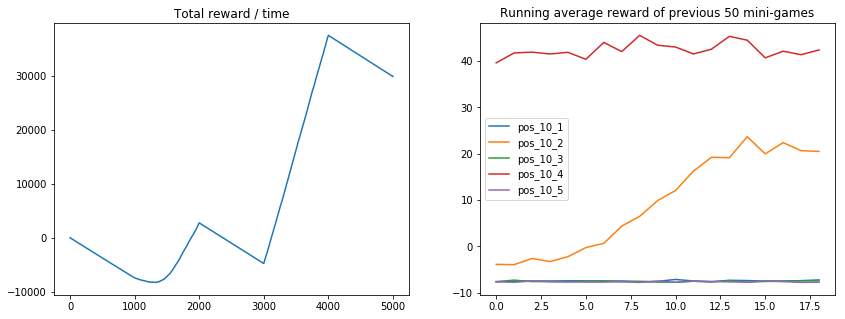

In [61]:
plot5(running_reward, running_means, exps)

In [62]:
display_timing_info(exps)

pos_10_1 took an average of 3368 seconds or 56.1 minutes to run
pos_10_2 took an average of 3657 seconds or 61.0 minutes to run
pos_10_3 took an average of 3417 seconds or 57.0 minutes to run
pos_10_4 took an average of 3496 seconds or 58.3 minutes to run
pos_10_5 took an average of 3399 seconds or 56.7 minutes to run


### 30 hidden neurons

In [65]:
avg_over = 50
exps = pos[10:15]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

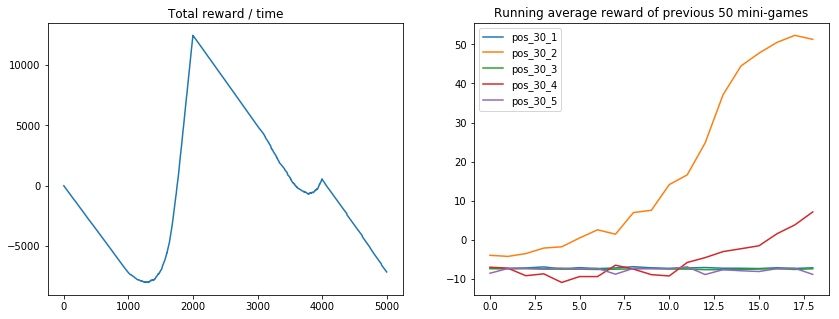

In [66]:
plot5(running_reward, running_means, exps)

In [67]:
display_timing_info(exps)

pos_30_1 took an average of 1477 seconds or 24.6 minutes to run
pos_30_2 took an average of 1515 seconds or 25.3 minutes to run
pos_30_3 took an average of 3381 seconds or 56.4 minutes to run
pos_30_4 took an average of 3807 seconds or 63.5 minutes to run
pos_30_5 took an average of 1541 seconds or 25.7 minutes to run


## Relative positions of the paddle to target location, and velocity of the paddle
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [73]:
avg_over = 50
exps = pos_vel[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

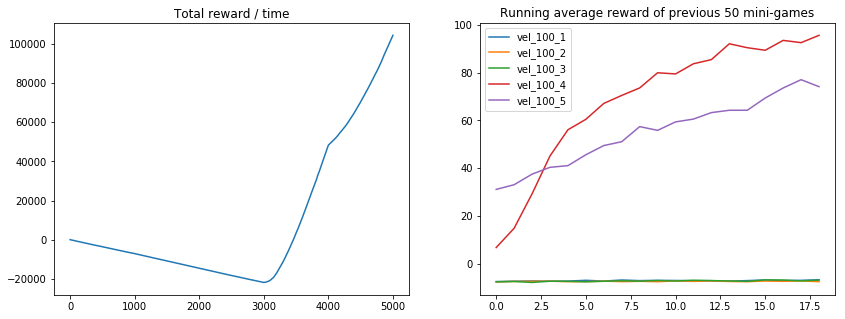

In [74]:
plot5(running_reward, running_means, exps)

In [75]:
display_timing_info(exps)

vel_100_1 took an average of 1689 seconds or 28.2 minutes to run
vel_100_2 took an average of 1668 seconds or 27.8 minutes to run
vel_100_3 took an average of 1668 seconds or 27.8 minutes to run
vel_100_4 took an average of 1806 seconds or 30.1 minutes to run
vel_100_5 took an average of 1816 seconds or 30.3 minutes to run


### 10 hidden neurons

In [76]:
avg_over = 50
exps = pos_vel[5:10]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

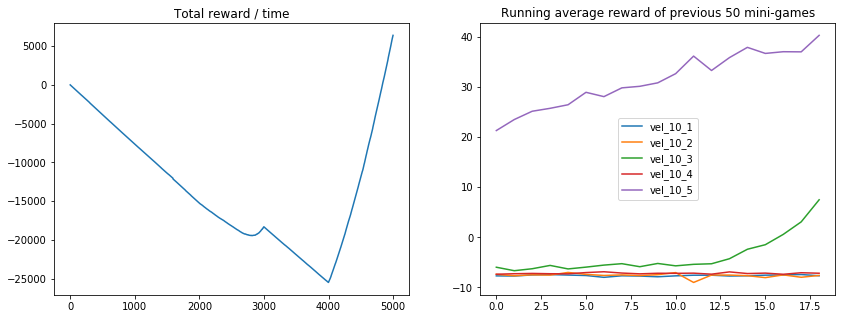

In [77]:
plot5(running_reward, running_means, exps)

In [78]:
display_timing_info(exps)

vel_10_1 took an average of 3738 seconds or 62.3 minutes to run
vel_10_2 took an average of 3756 seconds or 62.6 minutes to run
vel_10_3 took an average of 3686 seconds or 61.4 minutes to run
vel_10_4 took an average of 3683 seconds or 61.4 minutes to run
vel_10_5 took an average of 3746 seconds or 62.4 minutes to run


### 30 hidden neurons

In [79]:
avg_over = 50
exps = pos_vel[10:15]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

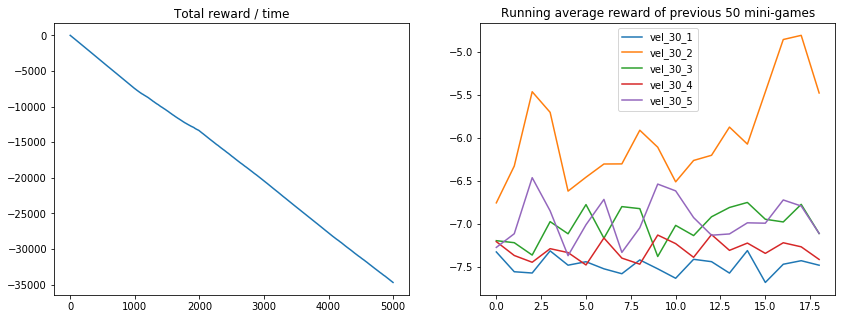

In [80]:
plot5(running_reward, running_means, exps)

In [81]:
display_timing_info(exps)

vel_30_1 took an average of 3703 seconds or 61.7 minutes to run
vel_30_2 took an average of 3691 seconds or 61.5 minutes to run
vel_30_3 took an average of 3694 seconds or 61.6 minutes to run
vel_30_4 took an average of 3691 seconds or 61.5 minutes to run
vel_30_5 took an average of 3691 seconds or 61.5 minutes to run


## Relative positions of the paddle to target location, and velocity of the paddle, and the acceleration of the paddle
10, 30, 100 hidden neurons: 5 experiment runs each

### 100 hidden neurons

In [82]:
avg_over = 50
exps = pos_vel_acc[0:5]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

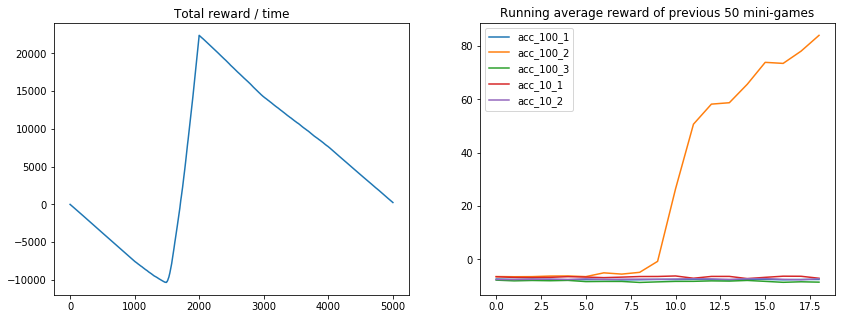

In [83]:
plot5(running_reward, running_means, exps)

In [84]:
display_timing_info(exps)

acc_100_1 took an average of 1670 seconds or 27.8 minutes to run
acc_100_2 took an average of 1744 seconds or 29.1 minutes to run
acc_100_3 took an average of 1793 seconds or 29.9 minutes to run
acc_10_1 took an average of 3746 seconds or 62.4 minutes to run
acc_10_2 took an average of 3764 seconds or 62.7 minutes to run


### 10 hidden neurons

In [87]:
avg_over = 50
exps = pos_vel_acc[3:8]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

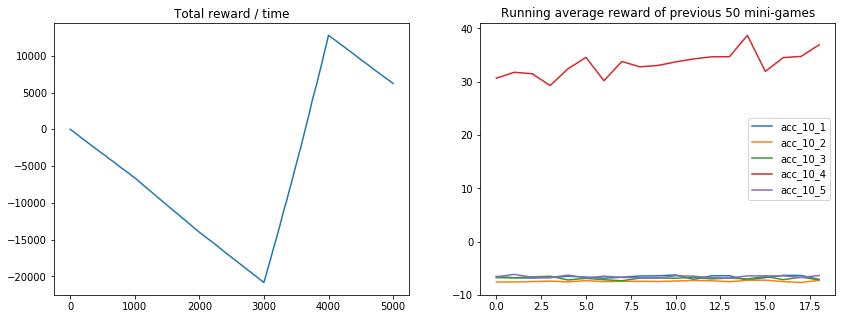

In [88]:
plot5(running_reward, running_means, exps)

In [89]:
display_timing_info(exps)

acc_10_1 took an average of 3746 seconds or 62.4 minutes to run
acc_10_2 took an average of 3764 seconds or 62.7 minutes to run
acc_10_3 took an average of 3804 seconds or 63.4 minutes to run
acc_10_4 took an average of 3922 seconds or 65.4 minutes to run
acc_10_5 took an average of 3829 seconds or 63.8 minutes to run


### 30 hidden neurons

In [94]:
avg_over = 50
exps = pos_vel_acc[8:13]
running_reward, running_means, variances = get_exps_info(exps, avg_over=avg_over)

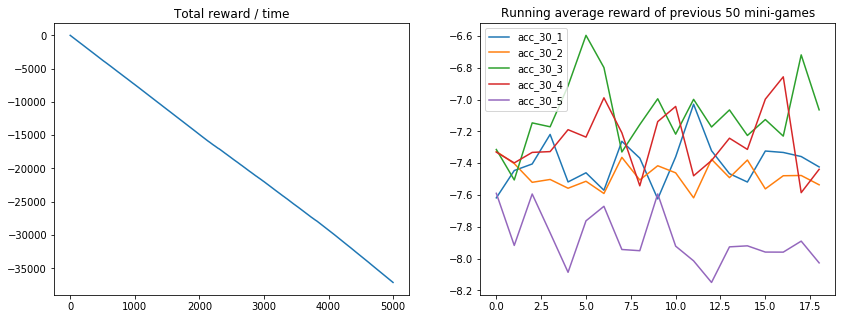

In [95]:
plot5(running_reward, running_means, exps)

In [96]:
display_timing_info(exps)

acc_30_1 took an average of 3815 seconds or 63.6 minutes to run
acc_30_2 took an average of 3800 seconds or 63.3 minutes to run
acc_30_3 took an average of 3830 seconds or 63.8 minutes to run
acc_30_4 took an average of 3806 seconds or 63.4 minutes to run
acc_30_5 took an average of 3854 seconds or 64.2 minutes to run


## Demo
 - OpenAI gym required: `pip install gym[atari]`
 - These are a good set of weights I found outside the scope of these experiments (for position + velocity model with 20 hidden units)
 - It can get good enough to get to wherever needed to return ball in time to return a volley that would have gone to that location(most of the time), BUT good weights were found through good choice of inputs and random initialization rather than optimization

In [97]:
import gym
import time

In [98]:
H = 20 # number of hidden layer neurons
paddle_height = 15
D = 2 ## 1. (where we are - where we need to go), 2. (paddle center last frame - paddle center this frame)
n_actions = 3

w1 = np.loadtxt('W1.weights', dtype=float)
w2 = np.loadtxt('W2.weights', dtype=float) 

model = {'W2': w2, 'W1':w1}

In [99]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    return np.exp(x) / np.sum(np.exp(x), axis=0)

def stable_softmax(X):
    exps = np.exp(X - np.max(X))
    return exps / np.sum(exps)

def prepro(I):
    """ prepro 210x160x3 uint8 frame into 6400 (80x80) 1D float vector """
    I = I[35:195] # crop
    I[I == 144] = 0 # erase background (background type 1)
    I[I == 109] = 0 # erase background (background type 2)
    I = I[:-1,:,0]
    return I.astype(np.float)

def policy_forward(x):
    h = np.dot(model['W1'], x)
    h[h<0] = 0 # ReLU nonlinearity
    logp = np.dot(h, model['W2'])
    p = stable_softmax(logp)
    return p, h # return probability of taking actions, and hidden state

def get_paddle_y(img, display_message=False):
    paddle_2_x = 139 # Leftmost position of paddle 2
    paddle_height = 15

    paddle_1_color = 213
    paddle_2_color = 92
    ball_color = 236

    ## In the beginning of the game, the paddle on the left and the ball are not yet present
    not_all_present = np.where(img == paddle_2_color)[0].size == 0
    if (not_all_present):
        if display_message:
            print("One or more of the objects is missing, returning an empty list of positions")
            print("(This happens at the first few steps of the game)")
        return -1

    paddle_2_top = np.unique(np.where(img == paddle_2_color)[0])[0]
    paddle_2_bot = paddle_2_top + paddle_height

    return (paddle_2_top + paddle_2_bot) / 2

In [101]:
render=True
delay=True

In [102]:
env = gym.make("Pong-v0")
observation = env.reset()
prev_x = None # used in computing the difference frame
reward_sum = 0
episode_number = 0

## Actions
action_up = 2
action_down = 5
action_nop = 0
actions = [action_up, action_down, action_nop]

observation = env.reset()

prev_paddle_y = -1
target_loc = 55
up_down_counter = 0
no_op_counter = 0
steps = 0

while(episode_number < 2):
    if render: 
        env.render()
        if delay: time.sleep(0.25)

    # preprocess the observation
    curr_img = prepro(observation)
    paddle_y = get_paddle_y(curr_img)

    if paddle_y != -1 and prev_paddle_y != -1:
        vel = paddle_y - prev_paddle_y
        x = np.array([target_loc - paddle_y, vel])
    else:
        vel = 0
        x = np.zeros(D)

    # forward the policy network and sample an action from the returned probability
    aprobs, h = policy_forward(x)
    action_idx = np.random.choice(n_actions, p=aprobs)
    action = actions[action_idx]
    y = np.zeros(n_actions)
    y[action_idx] = 1 # action taken

    # step the environment and get new measurements
    observation, reward, done, info = env.step(action)
    steps += 1

    ## ~~~~~~~~~~~~~~~~~~
    ## Reward Assignment
    ## ~~~~~~~~~~~~~~~~~~
    if paddle_y == -1:
        reward = 0
    elif np.abs(x[0]) < (paddle_height / 2) and vel == 0:
        reward = 2.5
        target_loc = int(np.random.random() * 100 + 20)
        print("reward achieved, new target location: " + str(target_loc))
    elif action == action_up or action == action_up:
        reward = -.01
        up_down_counter += 1
    else: # punish no-ops less
        reward = -.01 / 2
        no_op_counter += 1

    reward_sum += reward
    prev_paddle_y = paddle_y

    if done: # an episode finished
        print("Total reward for this ep({0:d}): ".format(episode_number) + str(reward_sum))
        episode_number += 1
        print("This epsiode lasted " + str(steps) + " steps")
        steps = 0
        reward_sum = 0
        observation = env.reset() # reset env
    prev_x = None

reward achieved, new target location: 52
reward achieved, new target location: 76
reward achieved, new target location: 79
reward achieved, new target location: 27
reward achieved, new target location: 29
reward achieved, new target location: 87
reward achieved, new target location: 109


KeyboardInterrupt: 

In [103]:
print(no_op_counter, up_down_counter)

(92, 24)
